In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import functools
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('ggplot')
%matplotlib inline

In [2]:
ALLEN_AI_RES_PATH = "../res/allenai/metadata.csv"

In [3]:
df_allen = pd.read_csv(ALLEN_AI_RES_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal']]
df_allen = df_allen.fillna('')
df_allen['is_pr'] = ~df_allen.source_x.isin(['biorxiv', 'medrxiv', 'arxiv']) # those sources are considered non-peer reviewed

print(len(df_allen.index))
df_allen.head(5)

59887


E:\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,source_x,title,abstract,publish_time,journal,is_pr
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True


In [4]:
def get_tfidf_vec(sr_str):
    tfidf = TfidfVectorizer(stop_words='english', min_df=.001, max_df=0.5)
    tfidf_data = tfidf.fit_transform(sr_str.values)
    return tfidf_data, tfidf

def get_avg_importance(tfidf_data, tfidf_vec):
    sum_counts = functools.reduce(lambda a,b: a+b, tfidf_data)
    word_freq = zip(tfidf_vec.get_feature_names(), sum_counts.A[0]/tfidf_data.shape[0])
    word_freq = sorted(word_freq, key=lambda x:x[1], reverse=True)
    df_imp = pd.DataFrame(word_freq, columns=['term', 'relevance']).set_index('term')
    return df_imp

## Title based tf-idf

In [5]:
td, tfidf = get_tfidf_vec(df_allen.title)

In [7]:
unique_sources = df_allen.source_x.unique()
df_list = []
for i, source in enumerate(unique_sources):
    tfidf_data = td.tocsr()[np.where(df_allen.source_x==source)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['source'] = source
    df_list.append(df_res)

df_ti_source = pd.concat(df_list)
df_ti_source.head(5)

,relevance,source
term,,
virus,0.035601,PMC
respiratory,0.026020,PMC
coronavirus,0.022880,PMC
infection,0.020548,PMC
human,0.018786,PMC


In [8]:
df_ti_rel = df_ti_source.set_index('source', append=True)
most_rel_terms = df_ti_source.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_terms

array(['covid', '19', 'coronavirus', '2019', 'novel', 'ncov', 'cov',
       'sars', 'pneumonia', 'wuhan'], dtype=object)

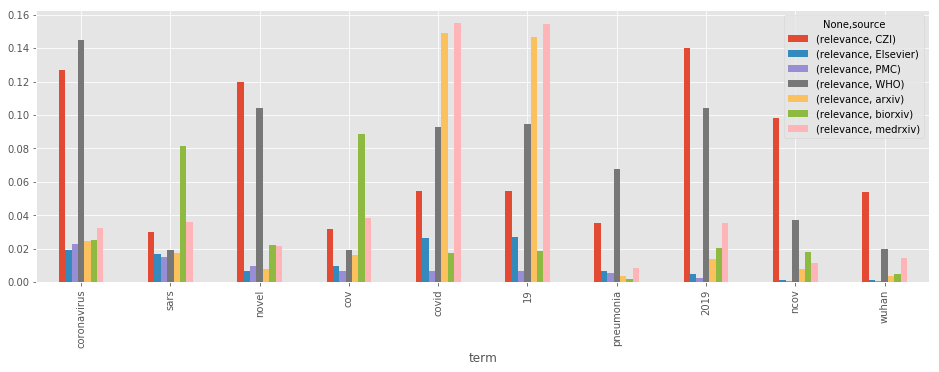

In [9]:
df_ti_rel[df_ti_rel.index.get_level_values(0).isin(most_rel_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [10]:
df_list = []
for i, val in enumerate([True, False]):
    tfidf_data = td.tocsr()[np.where(df_allen.is_pr == val)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['peer_reviewed'] = ('' if val else 'non-') + 'peer-reviewed'
    df_list.append(df_res)

df_ti_pr = pd.concat(df_list)
df_ti_pr.head(5)

,relevance,peer_reviewed
term,,
virus,0.030770,peer-reviewed
coronavirus,0.023675,peer-reviewed
respiratory,0.023232,peer-reviewed
infection,0.018786,peer-reviewed
viral,0.017194,peer-reviewed


In [11]:
df_ti_pr_rel = df_ti_pr.set_index('peer_reviewed', append=True)
most_rel_pr_terms = df_ti_pr.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_pr_terms

array(['covid', '19', 'cov', 'sars', 'virus', 'coronavirus', '2019',
       'model', 'epidemic', 'respiratory'], dtype=object)

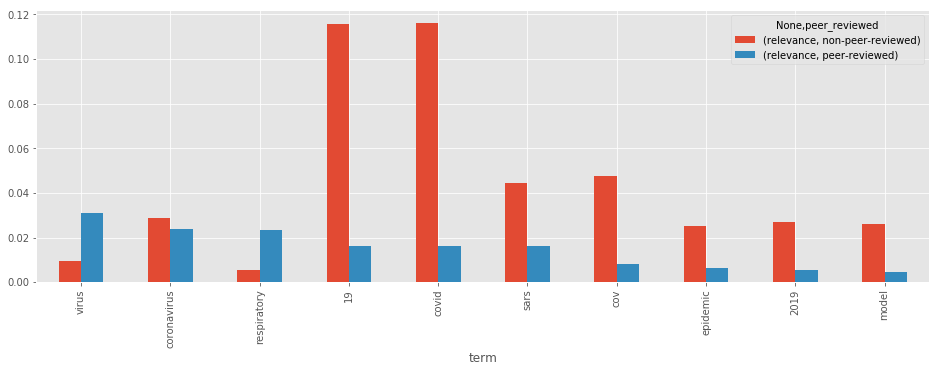

In [12]:
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(most_rel_pr_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [13]:
df_rel_dif = df_ti_pr_rel.reset_index().pivot(index='term',columns='peer_reviewed', values='relevance')
df_rel_dif['diff'] = df_rel_dif['non-peer-reviewed'] - df_rel_dif['peer-reviewed']
df_rel_dif['absdiff'] = np.abs(df_rel_dif['diff'])
df_rel_dif.sort_values(by='absdiff', ascending=False, inplace=True)
df_rel_dif.head(20)

peer_reviewed,non-peer-reviewed,peer-reviewed,diff,absdiff
term,,,,
covid,0.115907,0.016108,0.099799,0.099799
19,0.115666,0.016351,0.099315,0.099315
cov,0.047611,0.008098,0.039513,0.039513
sars,0.044595,0.015978,0.028617,0.028617
model,0.025872,0.004478,0.021394,0.021394
2019,0.026789,0.005448,0.021341,0.021341
virus,0.009463,0.030770,-0.021307,0.021307
epidemic,0.025027,0.006467,0.018560,0.018560
respiratory,0.005414,0.023232,-0.017819,0.017819


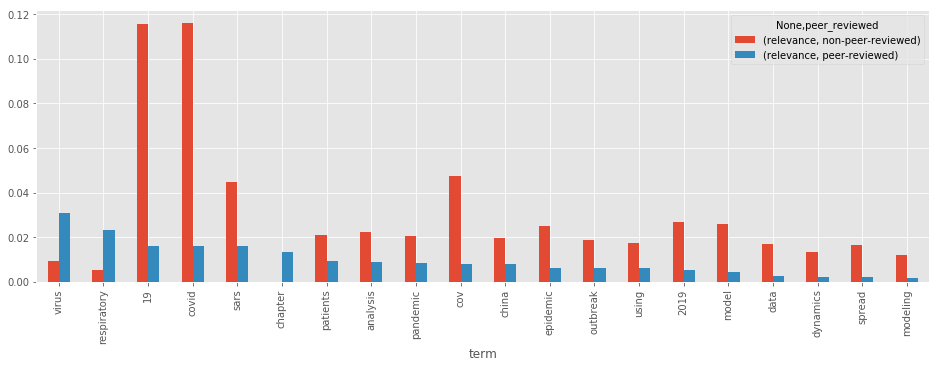

In [14]:
#excluded_list = ['virus', 'coronavirus', 'cov', '19','covid', '2019']
excluded_list = []
col_of_interest = [x for x in df_rel_dif.index[:20+len(excluded_list)] if x not in excluded_list]
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

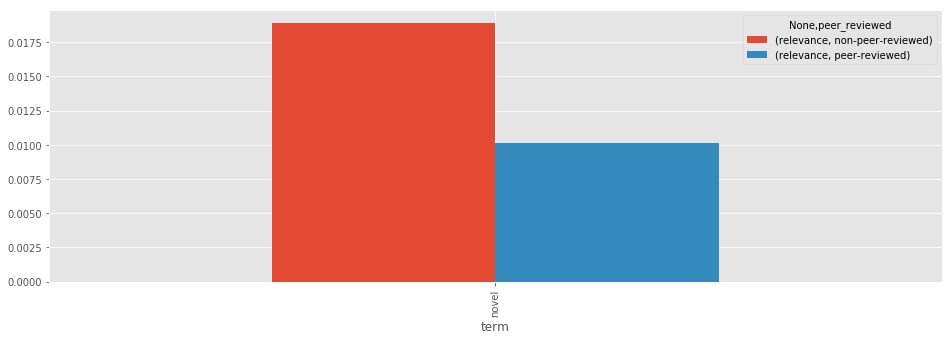

In [15]:
col_of_interest = ['novel', 'unprecedented', 'excellent', 'remarkable', 'exciting', 'brilliant']
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

## Abstract based tf-idf

In [16]:
td, tfidf = get_tfidf_vec(df_allen.abstract)

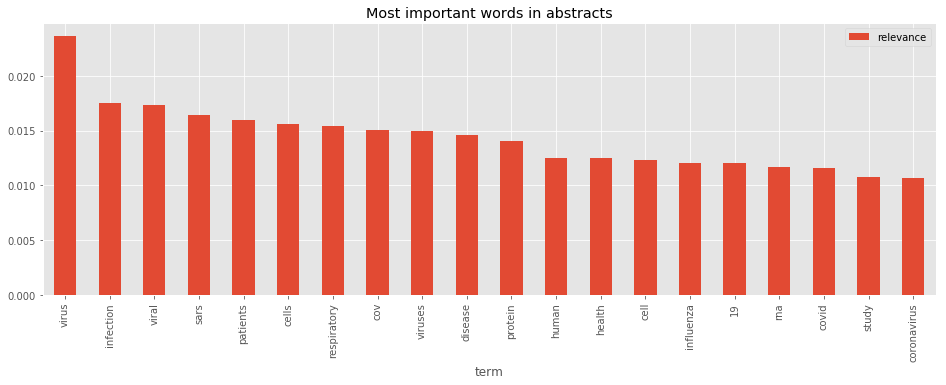

In [17]:
df_general = get_avg_importance(td,tfidf)
df_general.iloc[:20,].plot(kind='bar', title='Most important words in abstracts', figsize=(16,5))

In [18]:
unique_sources = df_allen.source_x.unique()
df_list = []
for i, source in enumerate(unique_sources):
    tfidf_data = td.tocsr()[np.where(df_allen.source_x==source)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['source'] = source
    df_list.append(df_res)

df_ti_source = pd.concat(df_list)
df_ti_source.head(5)

,relevance,source
term,,
virus,0.028319,PMC
viral,0.020587,PMC
infection,0.020408,PMC
cells,0.019945,PMC
respiratory,0.017839,PMC


In [19]:
df_ti_rel = df_ti_source.set_index('source', append=True)
most_rel_terms = df_ti_source.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_terms

array(['covid', '19', 'cov', 'sars', '2019', 'model', 'ncov', 'patients',
       'cases', 'china'], dtype=object)

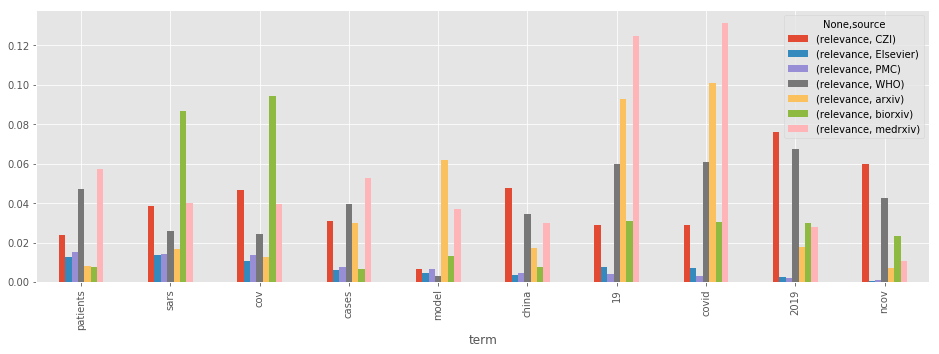

In [20]:
df_ti_rel[df_ti_rel.index.get_level_values(0).isin(most_rel_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [21]:
df_list = []
for i, val in enumerate([True, False]):
    tfidf_data = td.tocsr()[np.where(df_allen.is_pr == val)[0],:]
    df_res = get_avg_importance(tfidf_data, tfidf)
    df_res['peer_reviewed'] = ('' if val else 'non-') + 'peer-reviewed'
    df_list.append(df_res)

df_ti_pr = pd.concat(df_list)
df_ti_pr.head(5)

,relevance,peer_reviewed
term,,
virus,0.024127,peer-reviewed
viral,0.017653,peer-reviewed
infection,0.017408,peer-reviewed
cells,0.016146,peer-reviewed
respiratory,0.015775,peer-reviewed


In [22]:
df_ti_pr_rel = df_ti_pr.set_index('peer_reviewed', append=True)
most_rel_pr_terms = df_ti_pr.groupby('term').max().nlargest(10, 'relevance').index.values
most_rel_pr_terms

array(['covid', '19', 'cov', 'sars', 'model', 'cases', 'patients', 'data',
       'epidemic', 'number'], dtype=object)

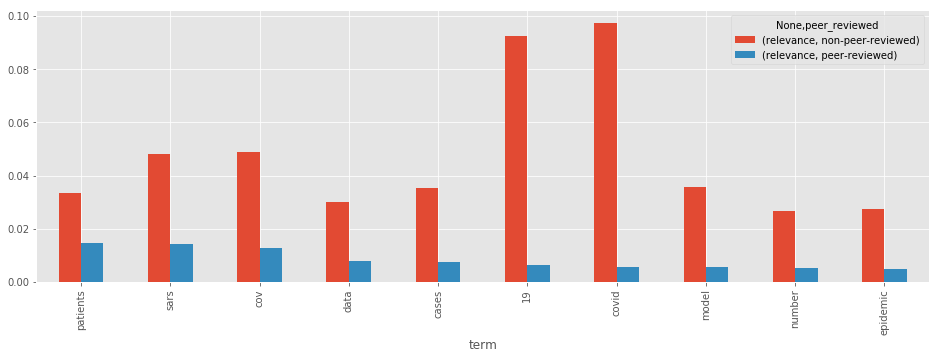

In [23]:
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(most_rel_pr_terms)].unstack().plot(kind='bar', figsize=(16,5))

In [24]:
df_rel_dif = df_ti_pr_rel.reset_index().pivot(index='term',columns='peer_reviewed', values='relevance')
df_rel_dif['diff'] = df_rel_dif['non-peer-reviewed'] - df_rel_dif['peer-reviewed']
df_rel_dif['absdiff'] = np.abs(df_rel_dif['diff'])
df_rel_dif.sort_values(by='absdiff', ascending=False, inplace=True)
df_rel_dif.head(20)

peer_reviewed,non-peer-reviewed,peer-reviewed,diff,absdiff
term,,,,
covid,0.097264,0.005693,0.091572,0.091572
19,0.092428,0.006457,0.085971,0.085971
cov,0.049027,0.012731,0.036296,0.036296
sars,0.047928,0.014270,0.033658,0.033658
model,0.035760,0.005601,0.030159,0.030159
cases,0.035349,0.007491,0.027858,0.027858
2020,0.024822,0.001471,0.023351,0.023351
2019,0.026404,0.003308,0.023096,0.023096
epidemic,0.027410,0.004740,0.022670,0.022670


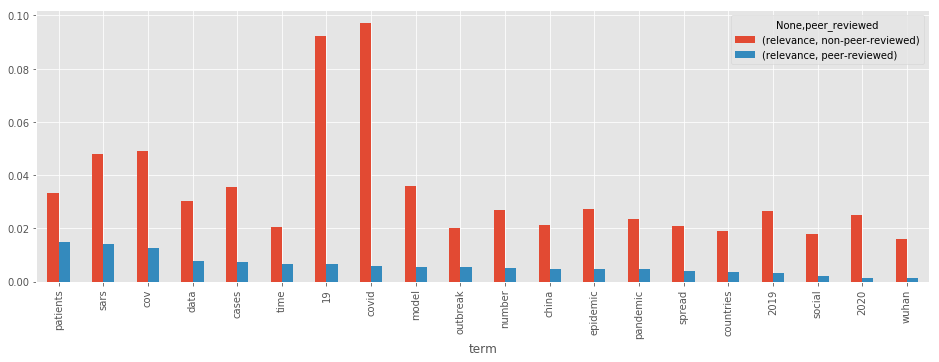

In [25]:
#excluded_list = ['virus', 'coronavirus', 'cov', '19','covid', '2019']
excluded_lists = []
col_of_interest = [x for x in df_rel_dif.index[:20+len(excluded_list)] if x not in excluded_list]
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

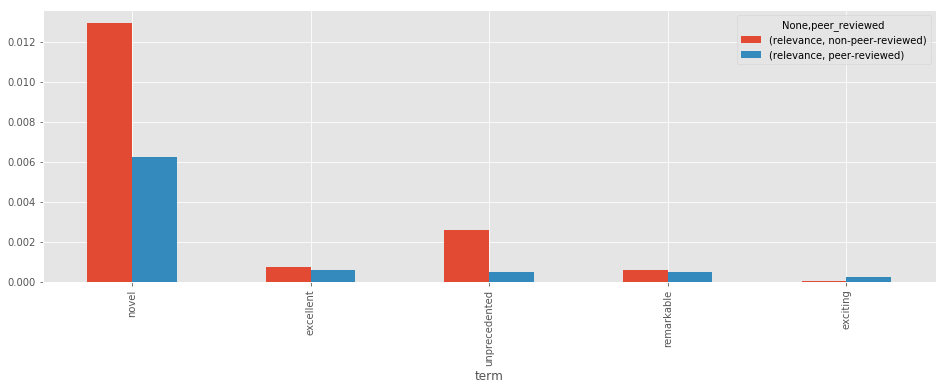

In [26]:
col_of_interest = ['novel', 'unprecedented', 'excellent', 'remarkable', 'exciting', 'brilliant']
df_ti_pr_rel[df_ti_pr_rel.index.get_level_values(0).isin(col_of_interest)].unstack().plot(kind='bar', figsize=(16,5))

In [27]:
df_allen[df_allen.abstract.str.contains('unknown')]

,source_x,title,abstract,publish_time,journal,is_pr
14,PMC,Viral Discovery and Sequence Recovery Using DN...,Because of the constant threat posed by emergi...,2003-11-17,PLoS Biol,True
46,PMC,Bioinformatic mapping of AlkB homology domains...,BACKGROUND: AlkB-like proteins are members of ...,2005-01-03,BMC Genomics,True
74,PMC,Subversion of Cellular Autophagosomal Machiner...,Infection of human cells with poliovirus induc...,2005-04-26,PLoS Biol,True
102,PMC,Conservation of pregnancy-specific glycoprotei...,BACKGROUND: Rodent and primate pregnancy-speci...,2005-06-29,BMC Evol Biol,True
206,PMC,Frequent detection of bocavirus DNA in German ...,BACKGROUND: In a substantial proportion of res...,2006-07-11,BMC Infect Dis,True
241,PMC,Adaptive evolution of the spike gene of SARS c...,BACKGROUND: It is believed that animal-to-huma...,2006-10-04,BMC Microbiol,True
266,PMC,Epidemiology and clinical outcome of virus-pos...,INTRODUCTION: Respiratory viruses are a major ...,2006-10-05,Crit Care,True
270,PMC,Long-Term Persistence of Robust Antibody and C...,Most of the individuals infected with SARS cor...,2006-12-20,PLoS One,True
333,PMC,Analysis of Intraviral Protein-Protein Interac...,The severe acute respiratory syndrome coronavi...,2007-05-23,PLoS One,True
345,PMC,Early efforts in modeling the incubation perio...,"The incubation period of infectious diseases, ...",2007-05-11,Emerg Themes Epidemiol,True
